## Mini-Project 2: Network Intrusion Detector


#### CSC 180  Intelligent Systems (Fall 2019)
#### Derrek Gass , Alexander Lee
#### 10-11-2019

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show

import collections

import io
import requests
import shutil
import os, json
import csv

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, regularizers




# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

    
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    

### Data Preparation

In [2]:
#encode_csv = X_test_prep.to_csv(r'data/nid_test_prep.csv', header=True, index=False)

In [102]:
X_test_prep = pd.read_csv(r'data/nid_test_prep.csv')

In [103]:
y=X_test_prep['outcome_normal.']
X_test_prep=X_test_prep.drop('outcome_normal.', axis=1)
X_numpy = X_test_prep.to_numpy()

In [104]:
x = X_numpy.reshape((len(X_test_prep), 1, len(X_test_prep.columns), 1))

In [105]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [106]:
x_train.shape

(86631, 1, 118, 1)

In [107]:
y_train.shape

(86631, 2)

In [108]:
x_test.shape

(28877, 1, 118, 1)

In [109]:
y_test.shape

(28877, 2)

### Convolutional Model

In [120]:
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, y_train.shape[1]), strides=(1, 1),
                 activation='tanh',
                 input_shape=(1, x_train.shape[2], 1)))
cnn.add(MaxPooling2D(pool_size=(1,2)))
cnn.add(Conv2D(x_train.shape[2], kernel_size=(1, y_train.shape[1]), strides=(1, 1),
                 activation='tanh'))
cnn.add(MaxPooling2D(pool_size=(1,2)))
    
    
cnn.add(Flatten())
cnn.add(Dense(32, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(y_train.shape[1], activation="softmax"))

cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [124]:
cnn.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1, 117, 64)        192       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 58, 64)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 57, 118)        15222     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 28, 118)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3304)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                105760    
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)              

In [123]:
import time

start_time = time.time()

# 1% of dataset
# Define batch_size and # of epochs
batch_size = 128

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="data/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

cnn.fit(x_train, y_train,     
        batch_size=batch_size,
        callbacks=[monitor, checkpointer],
        epochs=100,
        verbose=2,
        validation_data=(x_test, y_test))

cnn.load_weights('data/best_weights.hdf5')
elapsed_time = time.time() - start_time

print("Model: CNN, Activation: tanh, tanh, relu, softmax, Optimizer: adam, Kernel number/size: 118/64, 1x1")
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 86631 samples, validate on 28877 samples
Epoch 1/100
86631/86631 - 6s - loss: 0.0143 - acc: 0.9952 - val_loss: 0.0096 - val_acc: 0.9959
Epoch 2/100
86631/86631 - 5s - loss: 0.0126 - acc: 0.9954 - val_loss: 0.0091 - val_acc: 0.9964
Epoch 3/100
86631/86631 - 5s - loss: 0.0118 - acc: 0.9958 - val_loss: 0.0089 - val_acc: 0.9966
Epoch 4/100
86631/86631 - 5s - loss: 0.0111 - acc: 0.9963 - val_loss: 0.0076 - val_acc: 0.9977
Epoch 5/100
86631/86631 - 5s - loss: 0.0101 - acc: 0.9969 - val_loss: 0.0069 - val_acc: 0.9982
Epoch 6/100
86631/86631 - 5s - loss: 0.0096 - acc: 0.9970 - val_loss: 0.0062 - val_acc: 0.9978
Epoch 7/100
86631/86631 - 5s - loss: 0.0090 - acc: 0.9973 - val_loss: 0.0063 - val_acc: 0.9978
Epoch 8/100
86631/86631 - 5s - loss: 0.0088 - acc: 0.9974 - val_loss: 0.0061 - val_acc: 0.9979
Epoch 9/100
86631/86631 - 5s - loss: 0.0084 - acc: 0.9973 - val_loss: 0.0059 - val_acc: 0.9981
Epoch 10/100
86631/86631 - 5s - loss: 0.0083 - acc: 0.9975 - val_loss: 0.0072 - val_acc: 0.9974

In [126]:
# evaluate() computes the loss and accuracy
score = cnn.evaluate(x_test[0:100], y_test[0:100], verbose=2)

100/100 - 0s - loss: 0.0212 - acc: 0.9900


In [127]:
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.021198396283434704
Test accuracy: 0.9900000095367432


In [128]:
y_true = np.argmax(y_test[0:100],axis=1)
pred = cnn.predict(x_test[0:100])
pred = np.argmax(pred,axis=1)


score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))


Accuracy: 0.99
Averaged F1: 0.9899867765232429
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.98      1.00      0.99        56

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



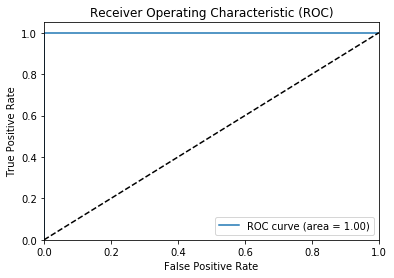

In [129]:
pred = cnn.predict(x_test[0:100])
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

In [130]:
cnn.load_weights('data/best_weights.hdf5')

[[43  1]
 [ 0 56]]


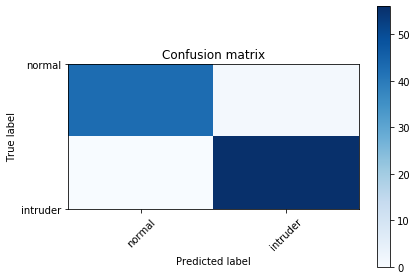

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.98      1.00      0.99        56

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [132]:
# Plot non-normalized confusion matrix
y_true = np.argmax(y_test[0:100],axis=1)
pred = cnn.predict(x_test[0:100])
pred = np.argmax(pred,axis=1)


cm = confusion_matrix(y_true, pred)
print(cm)
plt.figure()
plot_confusion_matrix(cm, ['normal','intruder'])
plt.show()
print(classification_report(y_true, pred))

Score (RMSE): 0.1


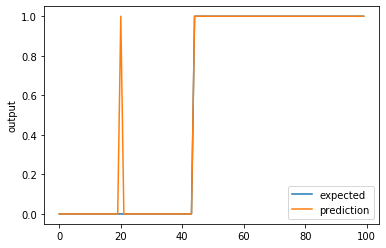

In [133]:
reg_score = np.sqrt(metrics.mean_squared_error(pred,y_true))
print("Score (RMSE): {}".format(reg_score))

# Plot the chart
chart_regression(pred, y_true, sort=True)

### Dense Model

In [134]:
X_test_prep = pd.read_csv(r'data/nid_test_prep.csv')

In [135]:
y=X_test_prep['outcome_normal.']
X_test_prep=X_test_prep.drop('outcome_normal.', axis=1)
X_numpy = X_test_prep.to_numpy()

In [136]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(X_numpy, y, test_size=0.25, random_state=42)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [137]:
# Defining a dense model
model = Sequential()
model.add(Dense(32, input_dim=X_numpy.shape[1], activation='tanh'))
model.add(Dense(6))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="data/best_fullyconnected_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,
          y_train,
          validation_data=(x_test,y_test),
          callbacks=[monitor,checkpointer],
          verbose=2,epochs=100)

model.load_weights('data/best_fullyconnected_weights.hdf5') # load weights from best model


elapsed_time = time.time() - start_time
print("Model: Sequential, Activation: tanh, Layers, count: 32, 6, 2  Optimizer: adam ")
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 86631 samples, validate on 28877 samples
Epoch 1/100
86631/86631 - 7s - loss: 0.0558 - acc: 0.9816 - val_loss: 0.0352 - val_acc: 0.9908
Epoch 2/100
86631/86631 - 6s - loss: 0.0195 - acc: 0.9940 - val_loss: 0.0203 - val_acc: 0.9935
Epoch 3/100
86631/86631 - 6s - loss: 0.0149 - acc: 0.9953 - val_loss: 0.0207 - val_acc: 0.9922
Epoch 4/100
86631/86631 - 7s - loss: 0.0119 - acc: 0.9964 - val_loss: 0.0169 - val_acc: 0.9939
Epoch 5/100
86631/86631 - 6s - loss: 0.0106 - acc: 0.9969 - val_loss: 0.0224 - val_acc: 0.9927
Epoch 6/100
86631/86631 - 7s - loss: 0.0109 - acc: 0.9968 - val_loss: 0.0107 - val_acc: 0.9976
Epoch 7/100
86631/86631 - 6s - loss: 0.0093 - acc: 0.9972 - val_loss: 0.0128 - val_acc: 0.9966
Epoch 8/100
86631/86631 - 6s - loss: 0.0088 - acc: 0.9974 - val_loss: 0.0083 - val_acc: 0.9979
Epoch 9/100
86631/86631 - 6s - loss: 0.0091 - acc: 0.9973 - val_loss: 0.0089 - val_acc: 0.9979
Epoch 10/100
86631/86631 - 6s - loss: 0.0087 - acc: 0.9975 - val_loss: 0.0084 - val_acc: 0.9978

In [138]:
# evaluate() computes the loss and accuracy
score = model.evaluate(x_test[0:100], y_test[0:100], verbose=2)

100/100 - 0s - loss: 0.0500 - acc: 0.9900


In [144]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 32)                3808      
_________________________________________________________________
dense_49 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 14        
Total params: 4,020
Trainable params: 4,020
Non-trainable params: 0
_________________________________________________________________


In [139]:
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.050018357187509535
Test accuracy: 0.9900000095367432


In [140]:
y_true = np.argmax(y_test[0:100],axis=1)
pred = model.predict(x_test[0:100])
pred = np.argmax(pred,axis=1)


score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

Accuracy: 0.99
Averaged F1: 0.9899867765232429
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.98      1.00      0.99        56

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



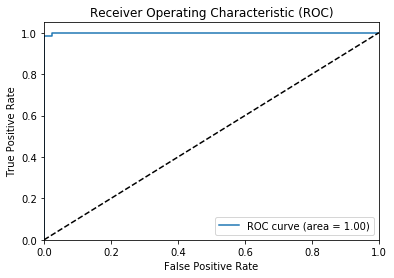

In [141]:
pred = model.predict(x_test[0:100])
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

[[43  1]
 [ 0 56]]


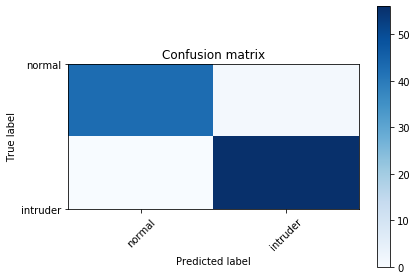

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.98      1.00      0.99        56

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [142]:
y_true = np.argmax(y_test[0:100],axis=1)
pred = model.predict(x_test[0:100])
pred = np.argmax(pred,axis=1)

cm = confusion_matrix(y_true, pred)
print(cm)
plt.figure()
plot_confusion_matrix(cm, ['normal','intruder'])
plt.show()
print(classification_report(y_true, pred))

Score (RMSE): 0.1


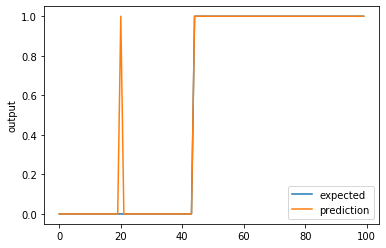

In [143]:
reg_score2 = np.sqrt(metrics.mean_squared_error(pred,y_true))
print("Score (RMSE): {}".format(reg_score2))

# Plot the chart
chart_regression(pred, y_true, sort=True)